In [1]:
#! /usr/bin/env python                                                                                            
# Run PSFEx for a set of exposures, including making any necessarily input files.                                 
# It also logs errors into a psf blacklist file.                                                                  
# Functions stolen from:                                                                                          
# https://github.com/rmjarvis/DESWL/blob/master/psf/run_piff.py                                                                                                                                        
# Probably lots of extraneous parameters and flags as well...   

!jupyter nbconvert --to script MeasurePSFres_new.ipynb

from __future__ import print_function
import os
import sys
import shutil
import logging
import datetime
import traceback
import numpy as np
import copy
import glob
import time
import fitsio
#import pixmappy
import pandas
import galsim
import galsim.des
import piff
import ngmix
from astropy.io import fits
import wget
from astropy.wcs import WCS
from ngmix import priors, joint_prior
import random
import pylab as P

import matplotlib
#matplotlib.use('Agg') # needs to be done before import pyplot                                                    
import matplotlib.pyplot as plt

[NbConvertApp] Converting notebook MeasurePSFres_new.ipynb to script
[NbConvertApp] Writing 43578 bytes to MeasurePSFres_new.py


In [2]:
# Don't skip columns in describe output  (default is 20, which is a bit too small)                                
pandas.options.display.max_columns = 200 

# Define the parameters for the blacklist                                                                         
# AC note:  a lot of these settings are not really used for the deep fields                                       
# currently...!   

# How many stars are too few or too many? 
FEW_STARS = 25
MANY_STARS_FRAC = 0.3
# How high is a high FWHM?  3.6 arcsec / 0.26 arcsec/pixel = 13.8 pixels                                          
#HIGH_FWHM = 13.8                                                                                                 
HIGH_FWHM = 3.6  # (We switched to measuring this in arcsec)                                                      
NSIG_T_OUTLIER = 4   # How many sigma for a chip to be an outlier in <T>.                                         

# Not copying flag vals for blacklist and psf catalog...                                                          
rng = galsim.BaseDeviate(1234)
MAX_CENTROID_SHIFT = 1.0
NOT_USED = 1
BAD_MEASUREMENT = 2
CENTROID_SHIFT = 4
OUTLIER = 8
FAILURE = 32
RESERVED = 64
NOT_STAR = 128
BLACK_FLAG_FACTOR = 512 # blacklist flags are this times the original exposure blacklist flag                     
# blacklist flags go up to 64,       

# Not copying array to convert ccdnum to detpos (this may or may not                                              
# be important)     

In [3]:
#put the stars data into a dataframe 

def read_psfex_stars(star_file, cat_file, logger): #combination of read findstars and read_image_header in MJ script
    """Read the PSFEx star selection                                                                              
    """
    print(star_file)
    if not os.path.exists(star_file):
        return None
    #dat = fits.open(star_file)
    #print(dat[2].columns)
    #dat = fits.open(cat_file)
    #print(dat[2].columns)
    
    # Read the output and make a DataFrome with the contents                                                      
    data = fitsio.read(star_file, ext=2)
    data = data.astype(data.dtype.newbyteorder('='))
    print("TESTING")
    flags_psf = data['FLAGS_PSF']
    source_id = data['SOURCE_NUMBER']
    x_im = data['X_IMAGE']
    y_im = data['Y_IMAGE']
    df = pandas.DataFrame(data={'SOURCE_NUMBER':source_id, 'X_IMAGE':x_im,
                          'Y_IMAGE':y_im, 'FLAGS_PSF':flags_psf})
    print(df)

    ntot = len(df)
    nstars = df['FLAGS_PSF'].sum()
    print('   found %d stars',ntot,nstars)
    logger.info('   found %d stars',nstars)
    #is_star = df['FLAGS_PSF'] == 1
    #print
    #print('   found %d good stars', len(is_star))

    # Add on some extra information from the sextractor catalog                                                   
    sdata = fitsio.read(cat_file, 2)
    #print(data['X_IMAGE'])
    #print(sdata['X_IMAGE'])
    assert len(data) == len(sdata)
    #print("magaper")
    #print(sdata['MAG_APER'])
    #print(sdata['MAG_APER'].shape)
    df['mag_aper'] = sdata['MAG_APER'][:,8]
    df['flux_radius'] = sdata['FLUX_RADIUS']
    #df['mag_auto'] = sdata['MAG_AUTO']
    
    #df = df[df.FLAGS_PSF == 0] #this line doesn't work!!!!!!!
    #print('   found %d good stars', len(df))
    plt.scatter(sdata['MAG_APER'][:,8], sdata['FLUX_RADIUS'],c='blue',label='FLAGS_PSF!=0 : %d' % (len(sdata['FLUX_RADIUS'])), marker='.',s=4) # , colormap='viridis')
    plt.scatter(sdata['MAG_APER'][np.where(data['FLAGS_PSF'] == 0),8], sdata['FLUX_RADIUS'][np.where(data['FLAGS_PSF'] == 0)],c='red',label='FLAGS_PSF==0 :%d' % (len(sdata['FLUX_RADIUS'][np.where(data['FLAGS_PSF'] == 0)])), marker='.',s=4) # , colormap='viridis')
    #plt.scatter(sdata['MAG_AUTO'], sdata['FLUX_RADIUS'],c='blue',label='FLAGS_PSF!=0 : %d' % (len(sdata['FLUX_RADIUS'])), marker='.',s=4) # , colormap='viridis')
    #plt.scatter(sdata['MAG_AUTO'][np.where(data['FLAGS_PSF'] == 0)], sdata['FLUX_RADIUS'][np.where(data['FLAGS_PSF'] == 0)],c='red',label='FLAGS_PSF==0 :%d' % (len(sdata['FLUX_RADIUS'][np.where(data['FLAGS_PSF'] == 0)])), marker='.',s=4) # , colormap='viridis')
  
    #plt.scatter(df['mag_aper'], df['flux_radius'], c='red',label='FLAGS_PSF==0', marker='.',s=4) # , colormap='viridis')
    plt.xlim((10,28))
    plt.ylim(0,10)
    #axs2[i].legend(sexstar['FLAGS_PSF'])
    plt.ylabel('FLUX_RADIUS')
    plt.xlabel('MAG_APER[:,8]')
    #plt.xlabel('MAG_AUTO')
    plt.title('%s'% band)
    plt.legend()
    plt.show()
    
    return df

In [4]:
#this is just a dublicate from the end in order to test why my mag_apers for "good" galaxies were higher than expected
"""
# Change locations to yours      
cdir = '/global/cscratch1/sd/aamon/DEEP/UVista'
cdir2= '/global/cscratch1/sd/amichoi/UltraVISTA'                                            

#band =  "J" #H, Ks, Y
bands=["J" ]#, "H", "Ks", "Y"]

for band in bands:
    print(band)
    
    pf = '%s/psf/UVISTA_%s_21_01_16_psfcat.psf' % (cdir2, band) # PSFEx image
    sf= '%s/psf/UVISTA_%s_21_01_16_psfex-starlist.fits' % (cdir2, band) #list of stars made from Sextractor and PSFEx
    cf = '%s/cat/UVISTA_%s_21_01_16_psfcat.fits' % (cdir2, band) #the output from extractor 
    im_f = '%s/UVISTA_%s_21_01_16_allpaw_skysub_015_dr3_rc_v5.fits' % (cdir, band)  #VIDEO_H_10_34.31_-4.80.cleaned.fits
    wt_f = '%s/UVISTA_%s_21_01_16_allpaw_skysub_015_dr3_rc_v5.weight.fits'%(cdir, band)   

    full_image = galsim.fits.read(im_f, hdu=0)
    wcs = full_image.wcs
    hdu = 0
    f = fitsio.FITS(im_f)
    header_list = f[hdu].read_header_list()
    header_list = [ d for d in header_list if 'CONTINUE' not in d['name'] ]
    h = fitsio.FITSHDR(header_list)
    #print(h)
    fwhm = h['PSF_FWHM']
    
    magzp = 30.0     
    mmlogging_level = logging.INFO
    logger = logging.getLogger('size_residual')
    df = read_psfex_stars(sf, cf, magzp, logger)
    """

'\n# Change locations to yours      \ncdir = \'/global/cscratch1/sd/aamon/DEEP/UVista\'\ncdir2= \'/global/cscratch1/sd/amichoi/UltraVISTA\'                                            \n\n#band =  "J" #H, Ks, Y\nbands=["J" ]#, "H", "Ks", "Y"]\n\nfor band in bands:\n    print(band)\n    \n    pf = \'%s/psf/UVISTA_%s_21_01_16_psfcat.psf\' % (cdir2, band) # PSFEx image\n    sf= \'%s/psf/UVISTA_%s_21_01_16_psfex-starlist.fits\' % (cdir2, band) #list of stars made from Sextractor and PSFEx\n    cf = \'%s/cat/UVISTA_%s_21_01_16_psfcat.fits\' % (cdir2, band) #the output from extractor \n    im_f = \'%s/UVISTA_%s_21_01_16_allpaw_skysub_015_dr3_rc_v5.fits\' % (cdir, band)  #VIDEO_H_10_34.31_-4.80.cleaned.fits\n    wt_f = \'%s/UVISTA_%s_21_01_16_allpaw_skysub_015_dr3_rc_v5.weight.fits\'%(cdir, band)   \n\n    full_image = galsim.fits.read(im_f, hdu=0)\n    wcs = full_image.wcs\n    hdu = 0\n    f = fitsio.FITS(im_f)\n    header_list = f[hdu].read_header_list()\n    header_list = [ d for d in head

In [4]:
def make_ngmix_prior(T, pixel_scale):
    # centroid is 1 pixel gaussian in each direction
    cen_prior=priors.CenPrior(0.0, 0.0, pixel_scale, pixel_scale)
    #print("1 ", cen_prior)
    # g is Bernstein & Armstrong prior with sigma = 0.1
    gprior=priors.GPriorBA(0.1)
    #print("2 ", gprior)
    #print("2b ",  T)
    #print(priors.LogNormal(T, 0.2))
    # T is log normal with width 0.2
    Tprior=priors.LogNormal(T, 0.2)
    #print("3 ", Tprior)
    # flux is the only uninformative prior
    Fprior=priors.FlatPrior(-10.0, 1.e10)
    #print("4 ", Fprior)
    prior=joint_prior.PriorSimpleSep(cen_prior, gprior, Tprior, Fprior)
    return prior


def ngmix_fit(im, wt, fwhm, x, y, logger, psfflag):     
    flag = 0
    dx, dy, g1, g2, flux = 0., 0., 0., 0., 0.
    T_guess = (fwhm / 2.35482)**2 * 2.
    T = T_guess
    #print('fwhm = %s, T_guess = %s'%(fwhm, T_guess))
    if psfflag==0:
        
            #hsm_dx,hsm_dy,hsm_g1,hsm_g2,hsm_T,hsm_flux,hsm_flag = hsm(im, None, logger)
            #logger.info('hsm: %s, %s, %s, %s, %s, %s, %s',hsm_dx,hsm_dy,hsm_g1,hsm_g2,hsm_T,hsm_flux,hsm_flag)
            #if hsm_flag != 0:
                #print('hsm: ',g1,g2,T,flux,hsm_flag)
                #print('Bad hsm measurement.  Reverting to g=(0,0) and T=T_guess = %s'%(T_guess))
                #T = T_guess
            #elif np.abs(np.log(T/T_guess)) > 0.5:
                #print('hsm: ',g1,g2,T,flux,hsm_flag)
                #print('T = %s is not near T_guess = %s.  Reverting to T_guess'%(T,T_guess))
            #T = T_guess
        #print("before wcs.local")
        #print(im.wcs.local)
        #print("before im.center")
        #print(im.true_center)
        #print("this line ", im.wcs.local(im.true_center))
        wcs = im.wcs.local(im.true_center)
        #print(wcs)
        try:
            #print("going to make prior", T,wcs.minLinearScale())
            prior = make_ngmix_prior(T, wcs.minLinearScale())
            #print("prior", prior)
        
            if galsim.__version__ >= '1.5.1':
                cen = im.true_center - im.origin
            else:
                cen = im.trueCenter() - im.origin()
            jac = ngmix.Jacobian(wcs=wcs, x=cen.x + x - int(x+0.5), y=cen.y + y - int(y+0.5))
            if wt is None:
                obs = ngmix.Observation(image=im.array, jacobian=jac)
            else:
                obs = ngmix.Observation(image=im.array, weight=wt.array, jacobian=jac)

            lm_pars = {'maxfev':4000}
            runner=ngmix.bootstrap.PSFRunner(obs, 'gauss', T, lm_pars, prior=prior)
            runner.go(ntry=3)

            ngmix_flag = runner.fitter.get_result()['flags']
            gmix = runner.fitter.get_gmix()
        except Exception as e:
            logger.info(e)
            logger.info(' *** Bad measurement (caught exception).  Mask this one.')
            print(' *** Bad measurement (caught exception).  Mask this one.')
            flag |= BAD_MEASUREMENT
            return dx,dy,g1,g2,T,flux,flag

        if ngmix_flag != 0:
            logger.info(' *** Bad measurement (ngmix flag = %d).  Mask this one.',ngmix_flag)
            flag |= BAD_MEASUREMENT
            print(' *** Bad measurement (ngmix flag = %d).  Mask this one.',ngmix_flag)

        dx, dy = gmix.get_cen()
        if dx**2 + dy**2 > MAX_CENTROID_SHIFT**2:
            logger.info(' *** Centroid shifted by %f,%f in ngmix.  Mask this one.',dx,dy)
            flag |= CENTROID_SHIFT
            print(' *** Centroid shifted by %f,%f in ngmix.  Mask this one.',dx,dy)

        g1, g2, T = gmix.get_g1g2T()
        if abs(g1) > 0.5 or abs(g2) > 0.5:
            logger.info(' *** Bad shape measurement (%f,%f).  Mask this one.',g1,g2)
            flag |= BAD_MEASUREMENT

        flux = gmix.get_flux() / wcs.pixelArea()  # flux is in ADU.  Should ~ match sum of pixels
    #logger.info('ngmix: %s %s %s %s %s %s %s',dx,dy,g1,g2,T,flux,flag)
    return dx, dy, g1, g2, T, flux, flag
    
#measure_star_shapes(df,im_f,noweight=False,wcs=wcs,use_ngmix=True, fwhm=FWHM,logger=logger)

In [5]:
def hsm(im, wt, logger):
    #print('im stats: ',im.array.min(),im.array.max(),im.array.mean(),np.median(im.array))                        
    #print('wt = ',wt)                                                                                            
    #if wt:                                                                                                       
        #print('im stats: ',wt.array.min(),wt.array.max(),wt.array.mean(),np.median(wt.array))                    
    flag = 0
    try:
        shape_data = im.FindAdaptiveMom(weight=wt, strict=False)
        #print('shape_data = ',shape_data)                                                                        
    except Exception as e:
        logger.info(e)
        logger.info(' *** Bad measurement (caught exception).  Mask this one.')
        flag |= BAD_MEASUREMENT

    if shape_data.moments_status != 0:
        logger.info('status = %s',shape_data.moments_status)
        logger.info(' *** Bad measurement (hsm status).  Mask this one.')
        flag |= BAD_MEASUREMENT

    if galsim.__version__ >= '1.5.1':
        dx = shape_data.moments_centroid.x - im.true_center.x
        dy = shape_data.moments_centroid.y - im.true_center.y
    else:
        dx = shape_data.moments_centroid.x - im.trueCenter().x
        dy = shape_data.moments_centroid.y - im.trueCenter().y
    #print('dx, dy = ',dx,dy)                                                                                     
    if dx**2 + dy**2 > MAX_CENTROID_SHIFT**2:
        logger.info(' *** Centroid shifted by %f,%f in hsm.  Mask this one.',dx,dy)
        flag |= CENTROID_SHIFT

    flux = shape_data.moments_amp
    #print('flux = ',flux)                             
    
    # Account for the image wcs                                                                                   
    if im.wcs.isPixelScale():
        g1 = shape_data.observed_shape.g1
        g2 = shape_data.observed_shape.g2
        T = 2 * shape_data.moments_sigma**2 * im.scale**2
        #print('simple shape = ',g1,g2,T)                                                                         
    else:
        e1 = shape_data.observed_shape.e1
        e2 = shape_data.observed_shape.e2
        s = shape_data.moments_sigma
        #print('simple shape = ',e1,e2,s)                                                                         

        if galsim.__version__ >= '1.5.1':
            jac = im.wcs.jacobian(im.true_center)
        else:
            jac = im.wcs.jacobian(im.trueCenter())
        M = np.matrix( [[ 1 + e1, e2 ], [ e2, 1 - e1 ]] ) * s*s
        J = jac.getMatrix()
        M = J * M * J.T

        e1 = (M[0,0] - M[1,1]) / (M[0,0] + M[1,1])
        e2 = (2.*M[0,1]) / (M[0,0] + M[1,1])
        T = M[0,0] + M[1,1]

        shear = galsim.Shear(e1=e1, e2=e2)
        g1 = shear.g1
        g2 = shear.g2
        #print('distorted shape = ',g1,g2,T) 
    return dx, dy, g1, g2, T, flux, flag


In [6]:
#"Measure shapes of the raw stellar images at each location.      
def measure_star_shapes(df, image_file, weight_file,noweight, wcs, use_ngmix, fwhm, logger):
    logger.info('Read in stars in file: %s',image_file)

    ind = df.index[df['FLAGS_PSF'] == 0]
    logger.info('ind = %s',ind)
    n_psf = len(ind)
    logger.info('n_psf = %s',n_psf)

    df['obs_dx'] = [ -999. ] * len(df)
    df['obs_dy'] = [ -999. ] * len(df)
    df['obs_e1'] = [ -999. ] * len(df)
    df['obs_e2'] = [ -999. ] * len(df)
    df['obs_T'] = [ -999. ] * len(df)
    df['obs_flux'] = [ -999. ] * len(df)
    df['obs_flag'] = [ NOT_STAR ] * len(df)
    df.loc[ind, 'obs_flag'] = 0

    if 'reserve' in df:
        #print("finding reserve but I want to ignore this")
        df.loc[df['reserve'], 'obs_flag'] |= RESERVED
        df.loc[~df['use'] & ~df['reserve'], 'obs_flag'] |= NOT_USED
    #else:
        #df.loc[~df['use'], 'obs_flag'] |= NOT_USED

    #df['ra'] = sdata['ALPHAWIN_J2000']
    #df['dec'] = sdata['DELTAWIN_J2000']
    #INSTEAD I'LL USE THE WCS AND THE X,Y TO GET RA AND DEC
    full_image = galsim.fits.read(image_file, hdu=0)
    w = WCS(image_file)
    xall = df['X_IMAGE']
    yall = df['Y_IMAGE']
    
    #print(xall,yall)
    world = w.wcs_pix2world(xall,yall,1)
    #print(world)
    #print(world[0])
    df['ra'] = world[0]
    df['dec'] = world[1]
 
    if wcs is not None:
        full_image.wcs = wcs

    if not noweight:
        #print("want weights! ", weight_file)
        #weight_file = image_file.replace(".fits", ".weight.fits")
        full_weight = galsim.fits.read(weight_file, hdu=0)
        full_weight.array[full_weight.array < 0] = 0.

    stamp_size = 48

    for i in ind:
        x = df['X_IMAGE'].iloc[i]
        y = df['Y_IMAGE'].iloc[i]

        #print('Measure shape for star at ',x,y)                                                                         
        b = galsim.BoundsI(int(x)-stamp_size/2, int(x)+stamp_size/2,
                           int(y)-stamp_size/2, int(y)+stamp_size/2)
        b = b & full_image.bounds
        im = full_image[b]

        if noweight:
            wt = None
        else:
            wt = full_weight[b]
            
        if use_ngmix:
            #print("using ngmix")
            #print(df['FLAGS_PSF'][i])
            dx, dy, e1, e2, T, flux, flag = ngmix_fit(im, wt, fwhm, x, y, logger,df['FLAGS_PSF'][i])
            
        else:
            dx, dy, e1, e2, T, flux, flag = hsm(im, wt, logger)
            
        #dx, dy, e1, e2, T, flux, flag = hsm(im, wt, logger)
        #print(dx, dy, e1, e2, T, flux, flag)
        #logger.info('ngmix measurement: (%f,%f,%f,%f,%f,%f).',dx,dy,e1,e2,T,flux)                                       
        if np.any(np.isnan([dx,dy,e1,e2,T,flux])):
            logger.info(' *** NaN detected (%f,%f,%f,%f,%f,%f).',dx,dy,e1,e2,T,flux)
            flag |= BAD_MEASUREMENT
        else:
            df.loc[i, 'obs_dx'] = dx
            df.loc[i, 'obs_dy'] = dy
            df.loc[i, 'obs_e1'] = e1
            df.loc[i, 'obs_e2'] = e2
            df.loc[i, 'obs_T'] = T
            df.loc[i, 'obs_flux'] = flux
            df.loc[i, 'obs_flag'] |= flag
    logger.info('final obs_flag = %s',df['obs_flag'][ind].values)
    #print('df[ind] = ',df.loc[ind].describe())                                                                          
    #flag_outliers(df, ind, 'obs', 4., logger) # This needs to be ported...                                              

    # Any stars that weren't measurable here, don't use for PSF fitting.                                                 
    df.loc[df['obs_flag']!=0, 'use'] = False

In [7]:
def measure_psfex_shapes(df, psfex_file, image_file, weight_file, noweight, wcs, use_ngmix, fwhm, logger):
    """Measure shapes of the PSFEx solution at each location.                                                            
    """
    logger.info('Read in PSFEx file: %s',psfex_file)

    ind = df.index[df['FLAGS_PSF'] == 0]
    logger.info('ind = %s',ind)
    n_psf = len(ind)
    logger.info('n_psf = %s',n_psf)

    df['psfex_dx'] = [ -999. ] * len(df)
    df['psfex_dy'] = [ -999. ] * len(df)
    df['psfex_e1'] = [ -999. ] * len(df)
    df['psfex_e2'] = [ -999. ] * len(df)
    df['psfex_T'] = [ -999. ] * len(df)
    df['psfex_flux'] = [ -999. ] * len(df)
    df['psfex_flag'] = [ NOT_STAR ] * len(df)
    df.loc[ind, 'psfex_flag'] = 0

    if 'reserve' in df:
        df.loc[df['reserve'], 'psfex_flag'] |= RESERVED
    #df.loc[~df['use'], 'psfex_flag'] |= NOT_USED

    try:
        psf = galsim.des.DES_PSFEx(psfex_file, image_file)
    except Exception as e:
        logger.info('Caught %s',e)
        df.loc[ind, 'psfex_flag'] = FAILURE
        return

    full_image = galsim.fits.read(image_file, hdu=0)

    if wcs is not None:
        full_image.wcs = wcs

    if not noweight:
        #print("want weights! ", weight_file)
        #weight_file = image_file.replace(".fits", ".weight.fits")
        full_weight = galsim.fits.read(weight_file, hdu=0)
        full_weight.array[full_weight.array < 0] = 0.
    
    

    stamp_size = 48

    for i in ind:
        x = df['X_IMAGE'].iloc[i]
        y = df['Y_IMAGE'].iloc[i]
        #print('Measure PSFEx model shape at ',x,y)                                                                      
        image_pos = galsim.PositionD(x,y)
        psf_i = psf.getPSF(image_pos)

        b = galsim.BoundsI(int(x)-stamp_size/2, int(x)+stamp_size/2,
                           int(y)-stamp_size/2, int(y)+stamp_size/2)
        b = b & full_image.bounds
        im = full_image[b]

        im = psf_i.drawImage(image=im, method='no_pixel')
        im *= df['obs_flux'].iloc[i]

        if noweight:
            wt = None
        else:
            wt = full_weight[b]
            var = wt.copy()
            var.invertSelf()
            im.addNoise(galsim.VariableGaussianNoise(rng, var))
            
        if use_ngmix:
            dx, dy, e1, e2, T, flux, flag = ngmix_fit(im, wt, fwhm, x, y, logger, df['FLAGS_PSF'][i])
        else:
            dx, dy, e1, e2, T, flux, flag = hsm(im, wt, logger)

        #dx, dy, e1, e2, T, flux, flag = hsm(im, wt, logger)
        if np.any(np.isnan([dx,dy,e1,e2,T,flux])):
            logger.info(' *** NaN detected (%f,%f,%f,%f,%f,%f).',dx,dy,e1,e2,T,flux)
            flag |= BAD_MEASUREMENT
        else:
            df.loc[i, 'psfex_dx'] = dx
            df.loc[i, 'psfex_dy'] = dy
            df.loc[i, 'psfex_e1'] = e1
            df.loc[i, 'psfex_e2'] = e2
            df.loc[i, 'psfex_T'] = T
            df.loc[i, 'psfex_flux'] = flux
        df.loc[i, 'psfex_flag'] |= flag
    #print('final psfex_flag = %s',df['psfex_flag'][ind].values)
    logger.info('final psfex_flag = %s',df['psfex_flag'][ind].values)
    #print('df[ind] = ',df.loc[ind].describe())                                                                          
    #flag_outliers(df, ind, 'psfex', 4., logger)                    

In [8]:
#not working
def wget( url, file):
    full_file = os.path.join(url,file)
    print(full_file)
    if not os.path.isfile(full_file):
        # Sometimes this fails with an "http protocol error, bad status line".
        # Maybe from too many requests at once or something.  So we retry up to 5 times.
        nattempts = 5
        cmd = 'wget -q --no-check-certificate %s'%(full_file)
        for attempt in range(1,nattempts+1):
            if os.path.exists(full_file):
                break
    return full_file

In [8]:
#want psf vs mag- brighter vs fatte6
def bin_by_mag(m, dT, dTfrac, min_mused, band, name):
    min_mag = min(m) #13.5
    max_mag = max(m) #21
    #print("min and max mag: ", min_mag, max_mag)
     
    mag_bins = np.linspace(min_mag,max_mag,21)
    #print('mag_bins = ',mag_bins)
    index = np.digitize(m, mag_bins)
    #print('len(index) = ',len(index))
    
    bin_dT = [dT[index == i].mean() for i in range(1, len(mag_bins))]
    #print('bin_dT = ',bin_dT)
    bin_dTfrac = [dTfrac[index == i].mean() for i in range(1, len(mag_bins))]
    
    bin_dT_err = [ np.sqrt(dT[index == i].var() / len(dT[index == i])) for i in range(1, len(mag_bins))  ]
    bin_dTfrac_err = [ np.sqrt(dTfrac[index == i].var() / len(dTfrac[index == i])) for i in range(1, len(mag_bins)) ]
    for i in range(1, len(mag_bins)):
        print('len(index) = ',len(dT[index == i]))
    """
    bin_dT_err=np.zeros(len(mag_bins)-1)
    for i in range(1, len(mag_bins)):
        if len(dT[index == i])==0:
            bin_dT_err[i] =0
        else:
            bin_dT_err[i] = np.sqrt(dT[index == i].var() / len(dT[index == i])) 
    print(bin_dT)
    print(bin_dT_err)  
    #bin_dT_err = [ np.sqrt(dT[index == i].var() / len(dT[index == i])) for i in range(1, len(mag_bins)) if len(dT[index == i])>0 ]
    #bin_dTfrac_err = [ np.sqrt(dTfrac[index == i].var() / len(dTfrac[index == i])) for i in range(1, len(mag_bins)) if len(dT[index == i])>0 ]
    for i in range(1, len(mag_bins)):
        print(i)
        print(len(dT[index == i]))
        #if len(dT[index == i])==0:
        print(bin_dT_err[i])
    """
    
    # Fix up nans
    for i in range(1,len(mag_bins)):
        if i not in index:
            bin_dT[i-1] = 0.
            bin_dTfrac[i-1] = 0.
            bin_dT_err[i-1] = 0.
            bin_dTfrac_err[i-1] = 0.
    fig, axes = plt.subplots(2,1, sharex=True)
    
    ax = axes[0]
    ax.set_ylim(-0.02,0.02)
    ax.plot([min_mag,max_mag], [0,0], color='black')
    ax.plot([min_mused,min_mused],[-1,1], color='Grey')
    ax.plot([19,19],[-1,1], color='Grey')
    #ax.fill( [min_mag,min_mag,min_mused,min_mused], [-1,1,1,-1], fill=True, color='Grey',alpha=0.3)
    ax.fill( [18.3,18.3,max_mag,max_mag], [0.003,-0.001,-0.001,0.003], fill=True, color='grey',alpha=0.3)
    t_line = ax.errorbar(mag_bins[:-1], bin_dT, yerr=bin_dT_err, color='darkturquoise', fmt='o')
    #ax.axhline(y=0.003, linewidth=4, color='grey')
    #ax.legend([t_line], [r'$\delta T$'])
    ax.set_ylabel(r'$(T_{\rm PSF} - T_{\rm model}) \quad({\rm arcsec}^2)$', fontsize='x-large')

    ax = axes[1]
    ax.set_ylim(-0.05,0.05)
    ax.plot([min_mag,max_mag], [0,0], color='black')
    ax.plot([min_mused,min_mused],[-1,1], color='Grey')
    ax.plot([19,19],[-1,1], color='Grey')
    #ax.fill( [min_mag,min_mag,min_mused,min_mused], [-1,1,1,-1], fill=True, color='Grey',alpha=0.3)
    t_line = ax.errorbar(mag_bins[:-1], bin_dTfrac, yerr=bin_dTfrac_err, color='darkturquoise', fmt='o')
    #ax.legend([t_line], [r'$\delta T$'])
    ax.set_ylabel(r'$(T_{\rm PSF} - T_{\rm model})/ T_{\rm PSF}$', fontsize='x-large')

    ax.set_xlim(min_mag,max_mag)
    ax.set_xlabel('%s-magnitude'% (band), fontsize='x-large')

    fig.set_size_inches(7.0,10.0)
    plt.tight_layout()
    name='dpsf_%s_%s_DEEP.pdf' % (name,band)
    #plt.savefig(name)
    plt.show()


In [10]:
def stickplot(x, y, xcomp, ycomp, colour, whisker_scale, labelpresent, xtickspresent, ytickspresent, clbupperlim, title=''):
    #P.figure(figsize=(16,12))                                                            
    #ax = P.subplot(111)           
    
    xsize=6
    ysize=10
    
    #fig, ax = plt.subplots()
    fig, axes = plt.subplots(2,1, sharex=True,figsize=(xsize, ysize))
    ax = axes[0]
    color_ax1 = fig.add_axes([0.4/xsize, 10.0/ysize, 1.7/xsize, 0.05/ysize])
    #color_ax2 = fig.add_axes([2.2/xsize, 10.0/ysize, 1.7/xsize, 0.05/ysize])
    ax.set_axis_bgcolor('white')
    print("check on count: ", len(x))

    theta = np.arctan2(ycomp, xcomp) / 2. #np.arctan(y,x) gives the arc tangent of y/x    
    e = np.hypot(xcomp,ycomp) #magnitude of g cmpnts                                      
    u = np.cos(theta) * e
    v = np.sin(theta) * e
    print(min(e))
    print(max(e))
    norm = P.mpl.colors.Normalize(min(colour), max(colour))  # set the color scale to a uniform value                                                                              

    #with warnings.catch_warnings():
    #  warnings.simplefilter('ignore')
    Q1 = ax.quiver(x, y, u, v, e, cmap='jet', pivot='middle',
                           headwidth=0, headlength=0, headaxislength=0, norm=norm,
                           width=0.004, scale=whisker_scale, clim=[0,clbupperlim])
    scalepercent=whisker_scale * 0.01

    #cbar = fig.colorbar(Q1, cax=ax , orientation='horizontal')
    #cbar.set_ticklabels(['0.00','0.02','0.04','0.06','0.08','0.10','0.12'])
    #cbar.ax.tick_params(labelsize=7, pad=6)

    #P.xlim([(min(ra) - 0.1),(max(ra) + 0.1)])
    #P.ylim([(min(dec) - 0.1),(max(dec) + 0.1)])
    P.xlim([(min(x) - 0.1),(max(x) + 0.1)])
    P.ylim([(min(y) - 0.1),(max(y) + 0.1)])

    ax.text(0.1, 0.88, title, transform=ax.transAxes,
              fontsize='x-small', ha='left', va='bottom', weight='bold',)

    # RN: I'm going to comment out the color bar here                                     
    #clb = P.colorbar(Q1, ax = axis)                                                      
    #clb.ax.tick_params(labelsize=8)                                                      

    #clb.set_label('Size (= moments[1] + moments[2])')                                    
    #clb.label.set_fontsize(9)                                                            
    print("here")    
    #ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    print("here")
    #fig.set_size_inches(7.0,10.0)
    #plt.tight_layout()
    plt.show()  
print("here")

here


In [11]:
def randomly_cull(array,percenttocut):
    numobjs=len(array)
    print(numobjs)
    numtocut=(percenttocut/100.)*np.float(numobjs)
    numtokeep=np.float(numobjs)-numtocut 
    print(numtokeep)
    keep=[random.randint(0,(numobjs-1)) for i in range(0,np.int(numtokeep))]
    #  print keep                                                                                                  
    return keep

In [13]:
#UVISTA
# Change locations    
cdir = '/global/cscratch1/sd/aamon/DEEP/UVista'
cdir2= '/global/cscratch1/sd/amichoi/DR4_UltraVISTA'    #DR4   
cdir3 = '/global/cscratch1/sd/itrharri/UltraVISTA_DR4/'

import warnings
bands=["J"] #,"H", "Ks", "Y"]#, "Y","Z"] #"J" , "H"]
#names=["2_52.92_-27.71",   "6_52.59_-27.62",  "11_52.26_-27.34", "16_52.15_-28.13" ]#, "5_52.59_-29.05" ]
#names=["19_11_18"] # FOR UVISTA DR4  ["21_01_16"] FOR UVISTA DR3 
names=["01_02"]
#string="015_dr4_rc_v2" #FOR UVISTA DR4 AND 015_dr3_rc_v5 for UVISTA DR3
#names=["6_36.71_-4.46"]  #XMM
#names=["11_9.44_-43.70","12_9.69_-44.87","13_9.97_-43.05","14_9.95_-44.31","15_9.95_-44.77","1_9.16_-44.04","2_8.90_-44.50","3_8.91_-44.68","4_8.91_-43.79"] #Elais
#names=["7_35.48_-4.54",8_35.02_-4.73","10_35.57_-4.91","14_36.62_-5.20","14_36.62_-5.38", 16_35.02_-5.46","4_36.07_-4.09","6_36.80_-4.64","9_37.08_-4.83"] #XMM J H
#names=["10_35.66_-4.91","15_36.44_-5.38","_5_34.03_-4.99"] #XMM Ks
#names=["11_9.46_-43.51","10_9.46_-43.24","12_9.49_-44.96","14_9.73_-43.24", "6_9.22_-44.40"]  #Elais Ks Z
#names=["10_9.43_-44.40","12_9.49_-44.96","14_9.73_-43.24", "6_9.22_-44.40"]  #Elais Y 

i=0
for band in bands:
    for name in names:
        print(band, name)
       
        #pf = '%s/psf/CURRENTSIZE_SAT10000_SNR3000/UVISTA_%s_%s_allpaw_skysub_%s_psfcat.psf' % (cdir2, band , name,string) # PSFEx image
        #sf= '%s/psf/CURRENTSIZE_SAT10000_SNR3000/UVISTA_%s_%s_allpaw_skysub_%s_psfex-starlist.fits' % (cdir2, band, name,string) #list of stars made from Sextractor and PSFEx
        #cf = '%s/cat/CURRENTSIZE_SAT10000_SNR3000/UVISTA_%s_%s_allpaw_skysub_%s_psfcat.fits' % (cdir2, band, name,string) #the output from extractor 
        #im_f = '%s/UVISTA_%s_%s_allpaw_skysub_%s.fits' % (cdir2, band, name,string)  #VIDEO_H_10_34.31_-4.80.cleaned.fits
        #wt_f = '%s/UVISTA_%s_%s_allpaw_skysub_%s.weight.fits' %(cdir2, band, name,string) 
        ###pf = '%s/psf/UVISTA_%s_%s_allpaw_skysub_%s_psfcat.psf' % (cdir3, band , name,string) # PSFEx image
        ###sf= '%s/psf/UVISTA_%s_%s_allpaw_skysub_%s_psfex-starlist.fits' % (cdir3, band, name,string) #list of stars made from Sextractor and PSFEx
        ###cf = '%s/cat/UVISTA_%s_%s_allpaw_skysub_%s_psfcat.fits' % (cdir3, band, name,string) #the output from extractor 
        #im_f = '%s/UVISTA_%s_%s_allpaw_skysub_%s.fits' % (cdir2, band, name,string)  #VIDEO_H_10_34.31_-4.80.cleaned.fits
        wt_f = '%s/UV_%s_%s_%s.weight.fits' %(cdir2, band, name,string)      
        ###
        pf = '%s/psf/UV_%s_%s_psfcat.psf' % (cdir3, band , name) # PSFEx image
        sf= '%s/psf/UV_%s_%s_psfex-starlist.fits' % (cdir3, band, name) #list of stars made from Sextractor and PSFEx
        cf = '%s/cat/UV_%s_%s_psfcat.fits' % (cdir3, band, name) #the output from extractor 
        im_f = '%s/UV_%s_%s.cleaned.fits' % (cdir2, band, name)  #VIDEO_H_10_34.31_-4.80.cleaned.fits
        wt_f = '%s/UV_%s_%s.weight.fits' %(cdir2, band, name)  

        print(sf,cf)
        #dat = fits.open(sf)
        #print(dat[2].columns)      
        
        full_image = galsim.fits.read(im_f, hdu=0)    
        wcs = full_image.wcs
        f = fitsio.FITS(im_f)
        hdu=0
        header_list = f[hdu].read_header_list()
        header_list = [ d for d in header_list if 'CONTINUE' not in d['name'] ]
        h = fitsio.FITSHDR(header_list)
        #print(h)
        FWHM = h['PSF_FWHM'] # this is for UV - video doesn't have fwhm in image header! 

        magzp = 30.0
        mmlogging_level = logging.INFO
        logger = logging.getLogger('size_residual')
        # Read in some useful values, such as position                                                                           
        df = read_psfex_stars(sf, cf, logger)
        #print(df)
        # Measure the hsm shapes on the stars in the actual image  
        #ind = df.index[df['FLAGS_PSF'] == 0]
        measure_star_shapes(
            df,im_f,wt_f, noweight=False,wcs=wcs,use_ngmix=True, fwhm=FWHM,logger=logger)
        # Measure      
        #print(list(df))
        measure_psfex_shapes(
            df,pf,im_f, wt_f,noweight=False,wcs=wcs,use_ngmix=True, fwhm=FWHM, logger=logger)

        #print(list(df))
        print("All objs: ", len(df))
        df = df[df.FLAGS_PSF == 0]
        print("Flag-good objs (PSF==0) : ", len(df))

        ####################################################
        #CUTS
        good = (df['psfex_T'].values!=-999)&(df['obs_T'].values!=-999)
        df=df[good]
        print("Good shape objs: ", len(df))
        ####################################################
        #PLOT
        def compute_res(d):
            de1 =  d['obs_e1']-d[prefix+'_e1']
            de2 =  d['obs_e2']-d[prefix+'_e2']
            dt =  (d['obs_T']-d[prefix+'_T'])
            dtfrac = dt/d['obs_T']
            print('mean dt = ',np.mean(dt))
            return dtfrac, dt , de1, de2

        prefix="psfex"
        fracsizeres, sizeres, e1res, e2res=compute_res(df)
        df['fracsizeres'], df['sizeres'], df['e1res'], df['e2res']  = compute_res(df)
        """
                
        if i==0:
    
            dfold=df
            
            print(len(df1)) 
        else: # i>0:  
            dfnew=df
            df = pandas.concat([dfold, dfnew])
            dfold=df
            print(len(df))    
                            
        i+=1"""
        
        # Plotting the distribution of residuals                                                                                 
        plt.hist(df['sizeres'], 30)
        plt.xlabel('T_res = PSF - obs', fontsize='x-large')
        plt.ylabel('Num good objects',fontsize='x-large')
        plt.title('%s'% band)
        #plt.savefig('UltraVISTA_J_resid.png',bbox_inches='tight')
        plt.figure(figsize=(12,12))
        plt.show()

        fig, ax = plt.subplots()
        hb=ax.hexbin(df['mag_aper'],df['sizeres'] ,bins='log')#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
        cb = fig.colorbar(hb, ax=ax)
        cb.set_label('log10(N)')
        plt.xlabel('%s mag_aper' %(band), fontsize='x-large')
        plt.ylabel('T_res', fontsize='x-large')
        plt.show()
        #plt.savefig('UltraVISTA_J_resid.png',bbox_inches='tight')


        #subset=randomly_cull(df,80)
        #keep=randomly_cull(df,percenttocut)
        #stickplot(df['ra'],df['dec'], e1res, e2res, sizeres, fracsizeres, 1, 'no', 'no', 'no',0.03)
        ##print("done")
        bin_by_mag(df['mag_aper'], df['sizeres'], df['fracsizeres'], 16.5, band, name)

#if i==0:
    
#from astropy.table import vstack, Table
#print("i=0")
#final = Table.from_pandas(df)
#else:
#t = Table.from_pandas(df)
#final=vstack([final, t])
#print(len(final))
#print(t)
#fname='PSFres_VIDEO_hsm.fits' #% (band)
#t.write(fname, overwrite=True, format='ascii')  
"""                                                                                                                      

                                               
 - also didn't take flag_outliers function from his script, and this might                                               
   be useful(?)           
"""


J 01_02
/global/cscratch1/sd/itrharri/UltraVISTA_DR4//psf/UV_J_01_02_psfex-starlist.fits /global/cscratch1/sd/itrharri/UltraVISTA_DR4//cat/UV_J_01_02_psfcat.fits
/global/cscratch1/sd/itrharri/UltraVISTA_DR4//psf/UV_J_01_02_psfex-starlist.fits


AttributeError: 'NoneType' object has no attribute 'index'

VIDEO_H_
VIDEO_J_3_36.44_-4.09_psfcat.psf
VIDEO_J_3_36.44_-4.09
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_J_3_36.44_-4.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_J_3_36.44_-4.09_psfex-starlist.fits
/global/cscratch1/sd/amichoi/VIDEO/XMM/cat/VIDEO_J_3_36.44_-4.09_psfcat.fits
FWHM:  5.44305
All objs:  2926
Flag-good objs (PSF==0) :  115
Good shape objs:  115
mean dt =  0.000124914467316
mean dt =  0.000124914467316
115
VIDEO_J_6_36.80_-4.46_psfcat.psf
VIDEO_J_6_36.80_-4.46
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_J_6_36.80_-4.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_J_6_36.80_-4.46_psfex-starlist.fits
/global/cscratch1/sd/amichoi/VIDEO/XMM/cat/VIDEO_J_6_36.80_-4.46_psfcat.fits
FWHM:  5.37898
All objs:  3561
Flag-good objs (PSF==0) :  92
Good shape objs:  92
mean dt =  -7.89685596082e-05
mean dt =  -7.89685596082e-05
207
VIDEO_J_15_35.39_-5.28_psfcat.psf
VIDEO_J_15_35.39_-5.28
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_J_15_35

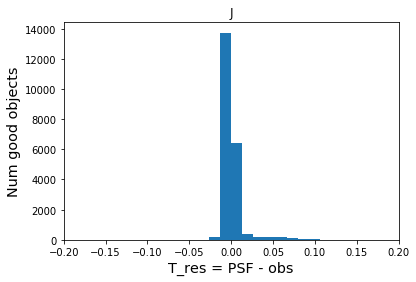

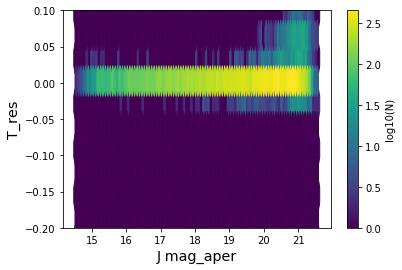

len(index) =  21
len(index) =  170
len(index) =  309
len(index) =  353
len(index) =  513
len(index) =  580
len(index) =  672
len(index) =  789
len(index) =  856
len(index) =  1009
len(index) =  1123
len(index) =  1295
len(index) =  1428
len(index) =  1574
len(index) =  1592
len(index) =  1961
len(index) =  2132
len(index) =  2354
len(index) =  2177
len(index) =  482


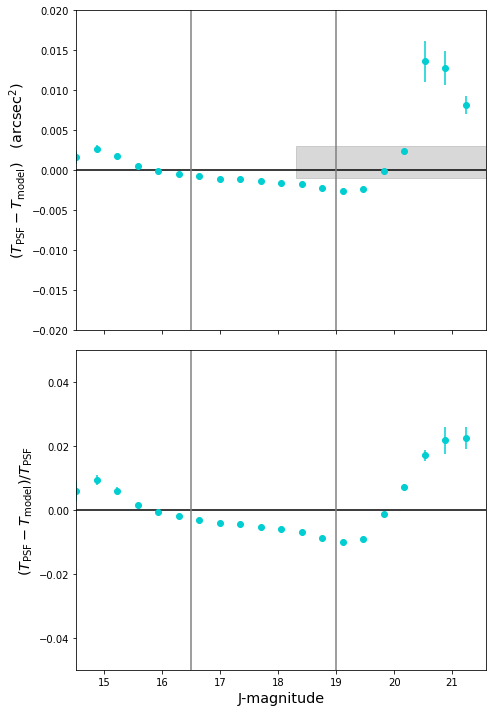

VIDEO_H_4_34.86_-5.54_psfcat.psf
VIDEO_H_4_34.86_-5.54
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_4_34.86_-5.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_4_34.86_-5.54_psfex-starlist.fits
/global/cscratch1/sd/amichoi/VIDEO/XMM/cat/VIDEO_H_4_34.86_-5.54_psfcat.fits
FWHM:  5.20729
All objs:  1692
Flag-good objs (PSF==0) :  81
Good shape objs:  81
mean dt =  0.00018697647738
mean dt =  0.00018697647738
81
VIDEO_H_1_36.99_-4.27_psfcat.psf
VIDEO_H_1_36.99_-4.27
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_36.99_-4.27_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_36.99_-4.27_psfex-starlist.fits
/global/cscratch1/sd/amichoi/VIDEO/XMM/cat/VIDEO_H_1_36.99_-4.27_psfcat.fits
FWHM:  5.21583
All objs:  2515
Flag-good objs (PSF==0) :  77
Good shape objs:  77
mean dt =  -0.000170930460902
mean dt =  -0.000170930460902
158
VIDEO_H_1_34.03_-5.36_psfcat.psf
VIDEO_H_1_34.03_-5.36
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_34.03_-5.36_psfcat.

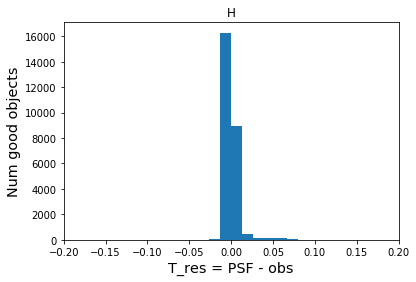

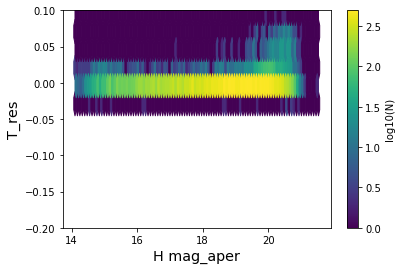

ZeroDivisionError: float division by zero

In [15]:
#VIDEO
"""
cdir= '/global/cscratch1/sd/amichoi/VIDEO' 
cdir2= '/global/cscratch1/sd/amichoi/VIDEO/XMM'  
        
import warnings
import os
#band="J"
bands=["J","H", "Ks"]
print(string)
for band in bands:
    string="VIDEO_%s_" % (band)
    i=0
    for fname in os.listdir(cdir2+'/psf'):
        if fname.startswith(string) and fname.endswith('psfcat.psf'): 
            print(fname)

            name, tmp = fname.split('_psfcat.psf', 1)
            print(name)
            #print(string2)
            #nam, tmp = string2.split('.cleaned.fits', 1)
            ##print(nam)
            #name=string+nam

            pf = '%s/psf/%s' % (cdir2, fname) # PSFEx image
            print(pf)
            sf= '%s/psf/%s_psfex-starlist.fits' % (cdir2, name) #list of stars made from Sextractor and PSFEx
            print(sf)
            cf = '%s/cat/%s_psfcat.fits' % (cdir2, name) #the output from extractor 
            print(cf)
            im_f = '%s/%s.cleaned.fits' % (cdir, name)  #VIDEO_H_10_34.31_-4.80.cleaned.fits
            wt_f = '%s/%s.weight.fits'%(cdir, name) 
            #get wcs and fwhm from image file
            dat = fitsio.read(sf, ext=2)

            FWHM = np.mean(dat['FWHM_PSF']) #video doesn't have fwhm in image header! 
            print('FWHM: ', FWHM)

            full_image = galsim.fits.read(im_f, hdu=0)    
            wcs = full_image.wcs
            f = fitsio.FITS(im_f)
            hdu=0
            header_list = f[hdu].read_header_list()
            header_list = [ d for d in header_list if 'CONTINUE' not in d['name'] ]
            h = fitsio.FITSHDR(header_list)
            #print(h)
            #FWHM = h['PSF_FWHM'] # this is for UV - video doesn't have fwhm in image header! 

            magzp = 30.0
            mmlogging_level = logging.INFO
            logger = logging.getLogger('size_residual')
            # Read in some useful values, such as position                                                                           
            df = read_psfex_stars(sf, cf, logger)
            # Measure the hsm shapes on the stars in the actual image                                                                
            measure_star_shapes(
                df,im_f,wt_f, noweight=False,wcs=wcs,use_ngmix=False, fwhm=FWHM,logger=logger)
            # Measure      
            #print(list(df))
            measure_psfex_shapes(
                df,pf,im_f, wt_f,noweight=False,wcs=wcs,use_ngmix=False, fwhm=FWHM, logger=logger)

            #print(list(df))
            print("All objs: ", len(df))
            df = df[df.FLAGS_PSF == 0]
            print("Flag-good objs (PSF==0) : ", len(df))

            ####################################################
            #CUTS
            good = (df['psfex_T'].values!=-999)&(df['obs_T'].values!=-999)
            df=df[good]
            print("Good shape objs: ", len(df))
            ####################################################
            #PLOT
            def compute_res(d):
                de1 =  d['obs_e1']-d[prefix+'_e1']
                de2 =  d['obs_e2']-d[prefix+'_e2']
                dt =  (d['obs_T']-d[prefix+'_T'])
                dtfrac = dt/d['obs_T']
                print('mean dt = ',np.mean(dt))
                return dtfrac, dt , de1, de2

            prefix="psfex"
            fracsizeres, sizeres, e1res, e2res=compute_res(df)
            df['fracsizeres'], df['sizeres'], df['e1res'], df['e2res']  = compute_res(df)


            if i==0:
                dfold=df
                #print(len(dfold)) 
            else: # i>0:  
                dfnew=df
                df = pandas.concat([dfold, dfnew])
                dfold=df
            print(len(dfold))    

            i+=1

    from astropy.table import vstack, Table
    final = Table.from_pandas(dfold)
    t = Table.from_pandas(df)
    final=vstack([final, t])
    print(len(final))
    print(t)
    fname='PSFres_VIDEO_X3_hsm_%s.fits' % (band)
    t.write(fname, overwrite=True, format='ascii') 

    # Plotting the distribution of residuals                                                                                 
    plt.hist(df['sizeres'], 30,range=(-0.2,0.2))
    plt.xlabel('T_res = PSF - obs', fontsize='x-large')
    plt.ylabel('Num good objects',fontsize='x-large')
    plt.title('%s'% band)
    plt.xlim(-0.2,0.2)
    plt.savefig('%sresid.png'% (string),bbox_inches='tight')
    plt.figure(figsize=(12,12))
    plt.show()

    fig, ax = plt.subplots()
    hb=ax.hexbin(df['mag_aper'],df['sizeres'] ,bins='log')#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('log10(N)')
    plt.xlabel('%s mag_aper' %(band), fontsize='x-large')
    plt.ylabel('T_res', fontsize='x-large')
    plt.ylim(-0.2,0.1)
    plt.show()
    plt.savefig('%smag_resid.png' % (string),bbox_inches='tight')

    #subset=randomly_cull(df,80)
    #keep=randomly_cull(df,percenttocut)
    #stickplot(df['ra'],df['dec'], e1res, e2res, sizeres, fracsizeres, 1, 'no', 'no', 'no',0.03)
    ##print("done")
    bin_by_mag(df['mag_aper'], df['sizeres'], df['fracsizeres'], 16.5, band, name)

    #if i==0:

    #from astropy.table import vstack, Table
    #print("i=0")
    #final = Table.from_pandas(df)
    #else:
    #t = Table.from_pandas(df)
    #final=vstack([final, t])
    #print(len(final))
    #print(t)
    #fname='PSFres_VIDEO_hsm.fits' #% (band)
    #t.write(fname, overwrite=True, format='ascii')  
"""
 

In [ ]:
  # Starfile has the following columns:
    # id: The original id from the SExtractor catalog
    # x: The x position
    # y: The y position
    # sky: The local sky value
    # noise: The estimated noise.  But these are all 0, so I think this isn't being calculated.
    # size_flags: Error flags that occurred when estimating the size
    # mag: The magnitude from SExtractor
    # sg: SExtractor's star/galaxy estimate.  Currently SPREAD_MODEL.  (Actually, currently none)
    # sigma0: The shapelet sigma that results in a b_11 = 0 shapelet parameter.
    # star_flag: 1 if findstars thought this was a star, 0 otherwise.
    
    #psfcat has the following columns:
    # name = 'VIGNET'; format = '3969E'; unit = 'count'; disp = 'G12.7'; dim = '(63, 63)'
    # name = 'XWIN_IMAGE'; format = '1D'; unit = 'pixel'; disp = 'F11.4'
    # name = 'YWIN_IMAGE'; format = '1D'; unit = 'pixel'; disp = 'F11.4'
    # name = 'X_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'
    # name = 'Y_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'
    # name = 'FLUX_APER'; format = '12E'; unit = 'count'; disp = 'G12.7'
    # name = 'FLUXERR_APER'; format = '12E'; unit = 'count'; disp = 'G12.7'
    # name = 'FLUX_MAX'; format = '1E'; unit = 'count'; disp = 'G12.7'
    # name = 'MAG_APER'; format = '12E'; unit = 'mag'; disp = 'F8.4'
    # name = 'MAGERR_APER'; format = '12E'; unit = 'mag'; disp = 'F8.4'
    # name = 'FLUX_RADIUS'; format = '1E'; unit = 'pixel'; disp = 'F10.3'
    # name = 'ELONGATION'; format = '1E'; disp = 'F8.3'
    # name = 'FLAGS'; format = '1I'; disp = 'I3'
    # name = 'SNR_WIN'; format = '1E'; disp = 'G10.4'
    # name = 'ERRAWIN_WORLD'; format = '1E'; unit = 'deg'; disp = 'G12.7'
    # name = 'ERRBWIN_WORLD'; format = '1E'; unit = 'deg'; disp = 'G12.7'
    # name = 'ERRTHETAWIN_J2000'; format = '1E'; unit = 'deg'; disp = 'F6.2'

In [ ]:
# Now plot some results:                                                                                                 
print("All objs: ", len(df))
#good = (df['psfex_T'].values!=-999)&(df['obs_T'].values!=-999)
#df=df[good]
print("Good objs: ", len(df))
#resid_T = psf_t-star_t
#dtfrac = psf_t/star_t
#mag=df['mag_aper']#[good]

def compute_res(d):
    dt =  (d['obs_T']-d[prefix+'_T'])
    dtfrac = dt/d['obs_T']
    #print('mean dt = ',np.mean(dt))
    return dtfrac, dt 

prefix="psfex"
fracsizeres, sizeres=compute_res(df)

# Plotting the distribution of residuals                                                                                 
plt.hist(sizeres, 30)
plt.xlabel('T_res = PSF - obs', fontsize='x-large')
plt.ylabel('Num good objects',fontsize='x-large')
#plt.savefig('UltraVISTA_J_resid.png',bbox_inches='tight')
plt.figure(figsize=(12,12))
plt.show()

fig, ax = plt.subplots()
hb=ax.hexbin(df['mag_aper'],sizeres ,bins='log')#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
plt.xlabel('mag_aper', fontsize='x-large')
plt.ylabel('T_res', fontsize='x-large')
#plt.savefig('UltraVISTA_J_resid.png',bbox_inches='tight')

bin_by_mag(df['mag_aper'], sizeres, fracsizeres, 15, band)


In [ ]:
6_52.59_-27.62